In [176]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import pandas as pd
from tqdm import tqdm
from astropy.visualization.hist import hist as fancyhist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [2]:
data = h5py.File('../../../sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

dataframe_list = []
for key in data.keys():
    dataset = data[key][:10000]
    df = pd.DataFrame(dataset)
    dataframe_list.append(df)

df_data = pd.concat(dataframe_list, axis=1)
labels = list(data.keys())
df_data.columns = labels
ind_det = labels.index('det')
ind_z = labels.index('z')
labels[ind_det], labels[ind_z] = labels[ind_z], labels[ind_det]
df_data = df_data[labels]

In [3]:
df_data

,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,z,iota,mtot,psi,q,ra,snr,det
0,-0.307201,0.276165,-0.430760,-0.161114,-0.092334,-0.414647,-0.329671,2.139659,1.809310,906.803562,1.286031,0.624780,-3.116784,0.822509,0
1,-0.734712,-0.498493,-0.298162,0.057532,-0.844992,0.014708,0.526740,2.438707,0.820820,59.102112,0.934308,0.986650,1.360291,1.093237,0
2,-0.057831,-0.703796,-0.354512,-0.215538,0.016323,0.130543,0.315799,1.869461,2.008206,44.602750,1.535520,0.286199,0.079973,1.305398,0
3,0.015260,-0.202467,-0.492768,-0.237033,-0.365363,-0.876192,0.432105,0.428061,2.018398,534.378032,3.064086,0.538882,-1.780558,9.112974,0
4,-0.016731,0.007848,0.005007,0.147519,0.231879,0.086716,-0.458711,0.772609,2.037363,573.821705,0.752211,0.846310,2.789289,17.525534,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.708728,0.121567,-0.176741,-0.230727,-0.075879,-0.246178,-0.340009,2.657802,1.087315,86.351265,3.042551,0.377024,1.121244,0.493245,0
9996,-0.005258,-0.749190,-0.064408,-0.094181,-0.344792,0.158509,-0.253670,0.205389,1.148764,851.363073,0.741488,0.777002,-2.559599,38.949247,1
9997,-0.069132,0.197611,0.220038,-0.142640,0.043409,-0.145898,0.346487,1.578344,0.674179,755.717002,2.328629,0.824103,-2.626533,5.503841,0
9998,0.395435,-0.810716,-0.177584,-0.835584,-0.189410,0.338516,0.724885,0.198390,2.168764,868.403736,2.619739,0.210378,2.223352,19.288054,1


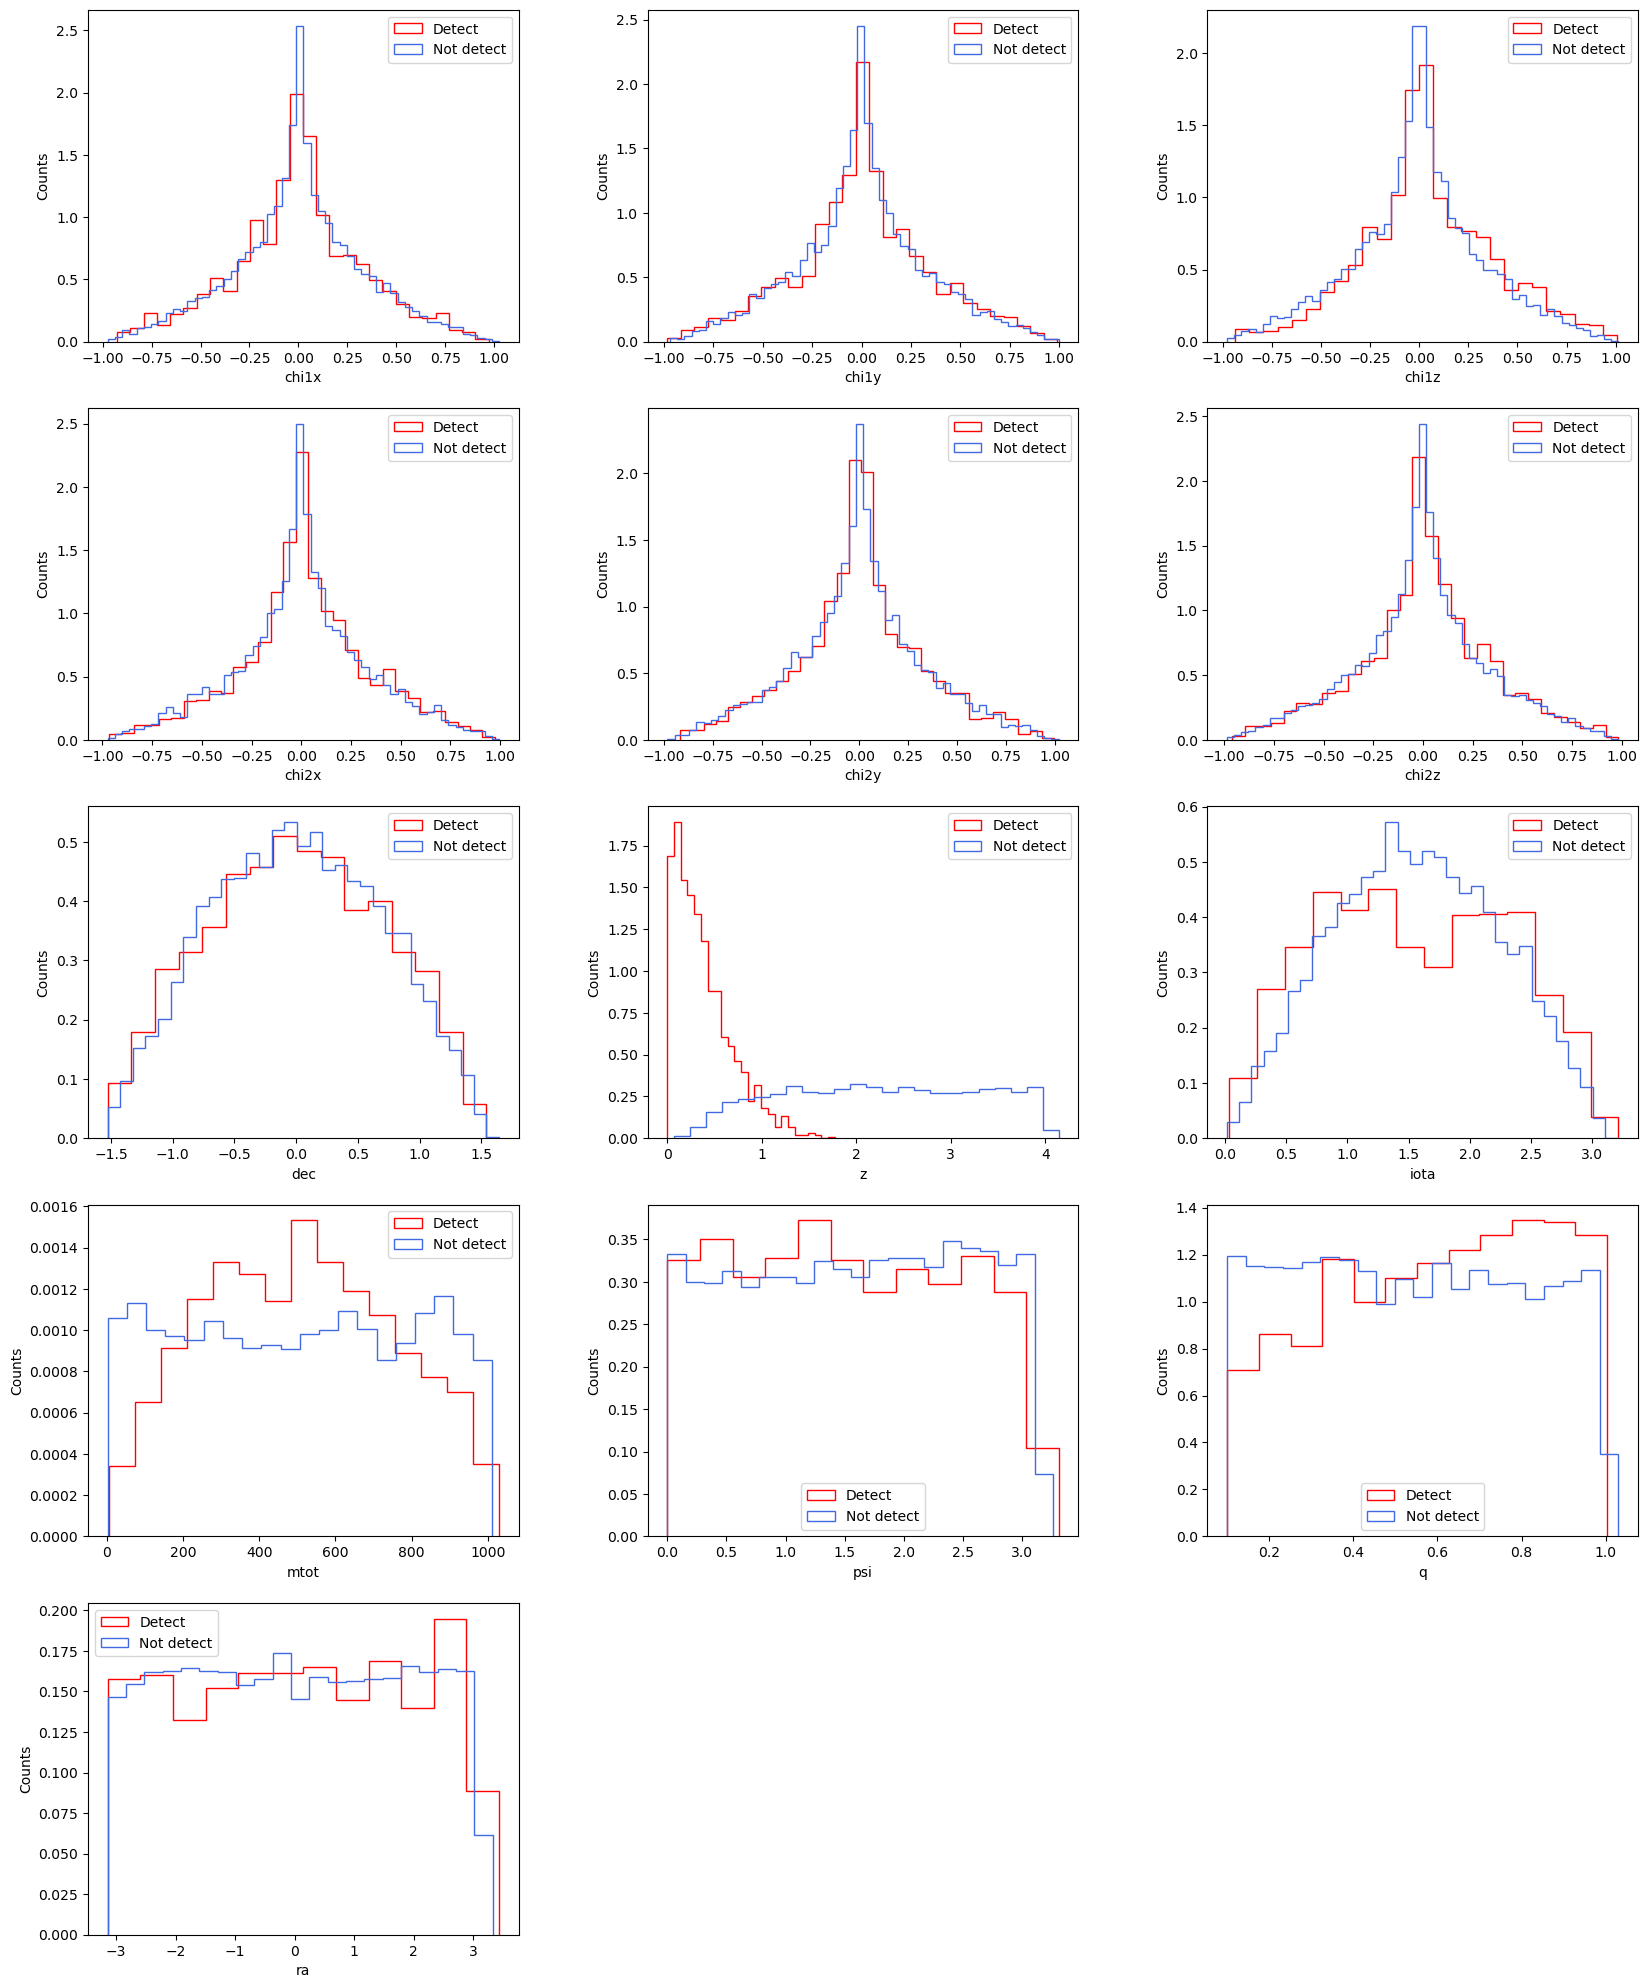

In [4]:
fig, axs = plt.subplots(5, 3, figsize=(20, 25))

k=0
for i in range(5):
    for j in range(3):
        if (df_data.columns[k]!='det') and (df_data.columns[k]!='snr'):
            fancyhist(df_data.loc[df_data['det'] == 1, df_data.columns[k]], bins="freedman", ax=axs[i,j], \
                      density=True, ec='red', histtype='step', label = 'Detect')
            fancyhist(df_data.loc[df_data['det'] == 0, df_data.columns[k]], bins="freedman", ax=axs[i,j], \
                      density=True, ec='royalblue', histtype='step', label = 'Not detect')
            axs[i,j].set_xlabel(df_data.columns[k])
            axs[i,j].set_ylabel('Counts')
            axs[i,j].legend()
        k+=1

for l in range(13, 15):
    fig.delaxes(axs.flatten()[l])

plt.subplots_adjust(wspace=0.3)
plt.show()

In [5]:
scaler = StandardScaler().set_output(transform="pandas")
data_scaled = scaler.fit_transform(df_data[labels[:13]])
X_train, X_test, y_train, y_test = train_test_split(data_scaled.to_numpy(), df_data['det'], test_size=0.3, random_state=42)

In [180]:
n_feature = np.arange(1, 14)
def compl_cont(clf, X_train, X_test, y_train, y_test):
    predictions = []
    confusion = []
    for i in tqdm(n_feature):
        clf.fit(X_train[:, :i], y_train)
        y_pred = clf.predict(X_test[:, :i])
    
        predictions.append(y_pred)
        confusion.append(confusion_matrix(y_test, y_pred))
    
    completeness, contamination = completeness_contamination(predictions, y_test)
    return completeness, contamination, confusion

def plots(clf, X_train, y_train, completeness, contamination, red = False):
    clf.fit(X_train, y_train)
    
    xlim = (np.min(X_train[:,0]), np.max(X_train[:,0]))
    ylim = (np.min(X_train[:,1]), np.max(X_train[:,1]))
    
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101), np.linspace(ylim[0], ylim[1], 101))
    xystack = np.vstack([xx.ravel(),yy.ravel()])
    Xgrid = xystack.T
    
    Z = clf.predict(Xgrid)
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure(figsize=(10, 4))
    fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                        left=0.1, right=0.95, wspace=0.2)
    
    ax = fig.add_subplot(121)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', s=10)
    ax.contour(xx, yy, Z, [0.7], colors='k')
    if red == False:
        ax.set_xlabel('z')
        ax.set_ylabel(r'$M_{tot}$')
    else:
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax = fig.add_subplot(222)
    ax.plot(n_feature, completeness, color = 'black', marker = 'o')
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylabel('Completeness')
    ax.grid(alpha=0.3)
    
    ax = fig.add_subplot(224)
    ax.plot(n_feature, contamination, color = 'black', marker = 'o')
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
    if red == False:
        ax.set_xlabel('N features')
    else:
        ax.set_xlabel('N components')
    ax.set_ylabel('Contamination')
    ax.grid(alpha=0.3)
    
    plt.subplots_adjust(wspace=0.3)
    plt.show()

## PCA

In [7]:
pca = PCA()
pca.fit(data_scaled)
evals = pca.explained_variance_ratio_ 
eigenvectors = np.asarray(pca.components_, dtype=float)
data_pca = pca.transform(data_scaled)

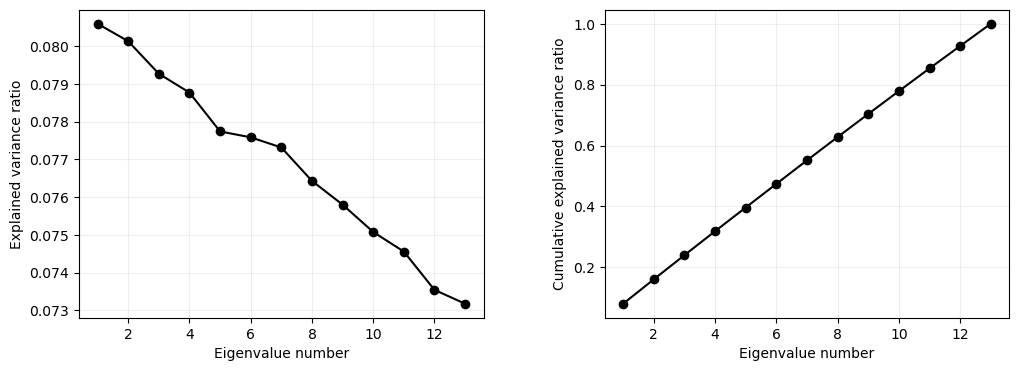

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(np.arange(1, len(evals)+1), evals, color = 'black', marker='o')
axs[0].set_xlabel('Eigenvalue number')
axs[0].set_ylabel('Explained variance ratio')
axs[0].grid(alpha=0.2)

axs[1].plot(np.arange(1, len(evals)+1), evals.cumsum(), color = 'black', marker='o')
axs[1].set_xlabel('Eigenvalue number')
axs[1].set_ylabel('Cumulative explained variance ratio')
axs[1].grid(alpha=0.2)

plt.subplots_adjust(wspace=0.3)
plt.show()

In [9]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, df_data['det'], test_size=0.3, random_state=42)

## Logistic regression

#### Without PCA

In [181]:
LR = LogisticRegression(class_weight='balanced')
completeness_LR, contamination_LR, confusion_LR = compl_cont(LR, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:00<00:00, 87.92it/s]


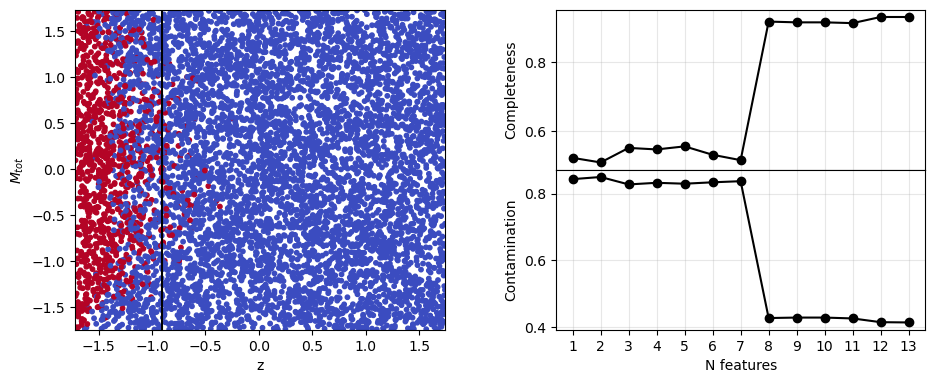

In [182]:
plots(LR, X_train[:,[7,9]], y_train, completeness_LR, contamination_LR)

#### With PCA

In [183]:
LR_pca = LogisticRegression(class_weight='balanced')
completeness_LR_pca, contamination_LR_pca, confusion_LR_pca = compl_cont(LR_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:00<00:00, 84.29it/s]


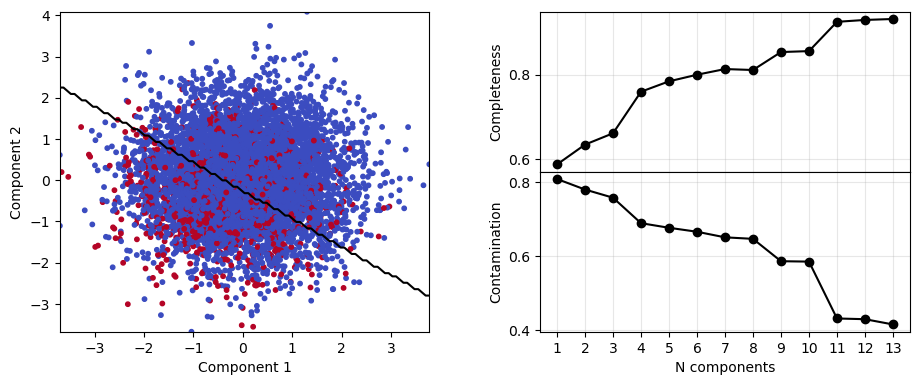

In [184]:
plots(LR_pca, X_train_pca[:,:2], y_train_pca, completeness_LR_pca, contamination_LR_pca, red = True)

In [185]:
print('Without PCA:')
print('Completeness:\n', completeness_LR)
print('Contamination:\n', contamination_LR)
print('\nWith PCA:')
print('Completeness:\n', completeness_LR_pca)
print('Contamination:\n', contamination_LR_pca)

Without PCA:
Completeness:
 [0.52115813 0.5077951  0.55011136 0.54565702 0.5545657  0.53006682
 0.51447661 0.91759465 0.91536748 0.91536748 0.91314031 0.93095768
 0.93095768]
Contamination:
 [0.84347826 0.84990125 0.82763433 0.83253589 0.82980178 0.83403068
 0.83732394 0.42777778 0.42916667 0.42916667 0.42657343 0.41538462
 0.41456583]

With PCA:
Completeness:
 [0.58797327 0.63474388 0.66146993 0.75946548 0.78396437 0.79955457
 0.81291759 0.81069042 0.85300668 0.85523385 0.92427617 0.92873051
 0.93095768]
Contamination:
 [0.80772032 0.7792409  0.75715454 0.68829982 0.67587477 0.66511194
 0.65004794 0.6459144  0.58549784 0.58441558 0.43072702 0.42876712
 0.41456583]


In [203]:
print('Confusion matrix\nWithout PCA:\n', confusion_LR[np.argmax(completeness_LR)])
print('\nWith PCA:\n', confusion_LR_pca[np.argmax(completeness_LR_pca)])

Confusion matrix
Without PCA:
 [[2254  297]
 [  31  418]]

With PCA:
 [[2255  296]
 [  31  418]]


## Support vector machines

#### Without PCA

In [15]:
crange = np.linspace(0.01, 10, 25)
k = 5
grid = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), {'C': crange}, cv= k, verbose = 2)
grid.fit(X_train, y_train)
best_c = grid.best_params_['C']
print(best_c)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .............................................C=0.01; total time=   0.5s
[CV] END .............................................C=0.01; total time=   0.6s
[CV] END .............................................C=0.01; total time=   0.5s
[CV] END .............................................C=0.01; total time=   0.5s
[CV] END .............................................C=0.01; total time=   0.5s
[CV] END ..........................................C=0.42625; total time=   0.3s
[CV] END ..........................................C=0.42625; total time=   0.3s
[CV] END ..........................................C=0.42625; total time=   0.3s
[CV] END ..........................................C=0.42625; total time=   0.3s
[CV] END ..........................................C=0.42625; total time=   0.4s
[CV] END ...........................................C=0.8425; total time=   0.4s
[CV] END ......................................

In [205]:
SVM = SVC(kernel='linear', class_weight='balanced', C = best_c)
completeness_SVC, contamination_SVC, confusion_SVC = compl_cont(SVM, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:44<00:00,  3.44s/it]


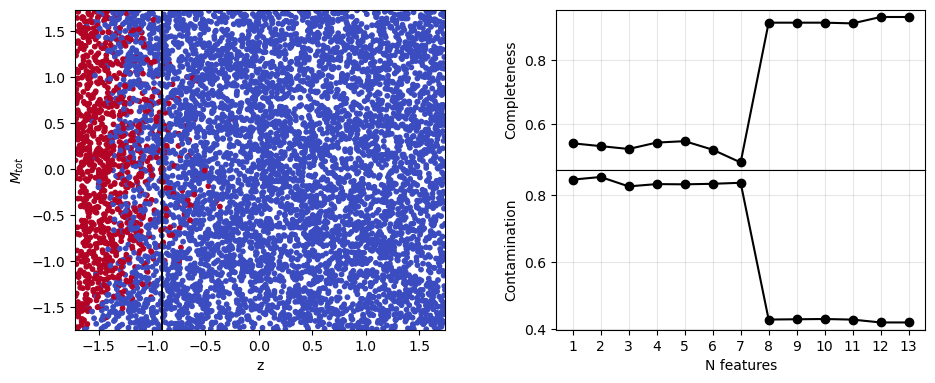

In [206]:
plots(SVM, X_train[:,[7,9]], y_train, completeness_SVC, contamination_SVC)

#### With PCA

In [18]:
grid = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), {'C': crange}, cv= k, verbose = 2)
grid.fit(X_train_pca, y_train_pca)
best_c_pca = grid.best_params_['C']
print(best_c_pca)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .............................................C=0.01; total time=   0.5s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.5s
[CV] END ..........................................C=0.42625; total time=   0.3s
[CV] END ..........................................C=0.42625; total time=   0.3s
[CV] END ..........................................C=0.42625; total time=   0.3s
[CV] END ..........................................C=0.42625; total time=   0.3s
[CV] END ..........................................C=0.42625; total time=   0.3s
[CV] END ...........................................C=0.8425; total time=   0.4s
[CV] END ......................................

In [207]:
SVM_pca = SVC(kernel='linear', class_weight='balanced', C = best_c_pca)
completeness_SVC_pca, contamination_SVC_pca, confusion_SVC_pca = compl_cont(SVM_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:28<00:00,  2.17s/it]


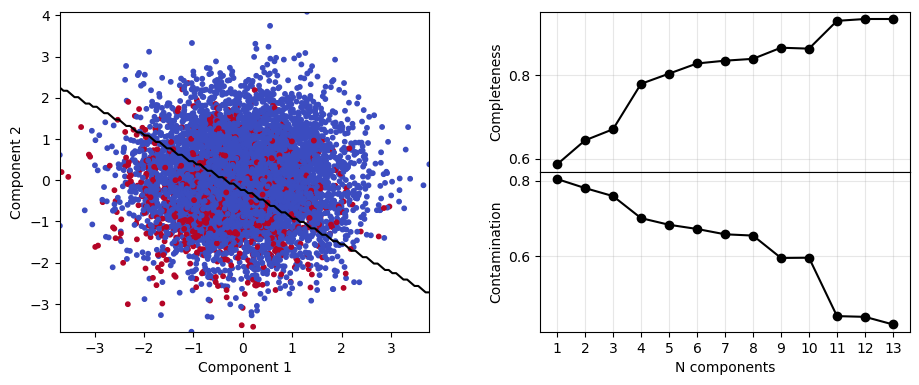

In [208]:
plots(SVM_pca, X_train_pca[:,:2], y_train_pca, completeness_SVC_pca, contamination_SVC_pca, red = True)

In [209]:
print('Without PCA:')
print('Completeness:\n', completeness_SVC)
print('Contamination:\n', contamination_SVC)
print('\nWith PCA:')
print('Completeness:\n', completeness_SVC_pca)
print('Contamination:\n', contamination_SVC_pca)

Without PCA:
Completeness:
 [0.5389755  0.53006682 0.52115813 0.54120267 0.54565702 0.51893096
 0.47884187 0.91759465 0.91759465 0.91759465 0.91536748 0.93541203
 0.93541203]
Contamination:
 [0.84556477 0.85335798 0.82537313 0.83218232 0.83149931 0.83309456
 0.83612805 0.42857143 0.42936288 0.43015214 0.42837274 0.4198895
 0.4198895 ]

With PCA:
Completeness:
 [0.5857461  0.64365256 0.67037862 0.77951002 0.80400891 0.8285078
 0.83518931 0.83964365 0.86636971 0.86414254 0.93095768 0.93541203
 0.93541203]
Contamination:
 [0.80431548 0.78039514 0.7592     0.70111016 0.68361087 0.67253521
 0.65846995 0.65507777 0.596054   0.5966736  0.44266667 0.44074567
 0.42068966]


In [210]:
print('Confusion matrix\nWithout PCA:\n', confusion_SVC[np.argmax(completeness_SVC)])
print('\nWith PCA:\n', confusion_SVC_pca[np.argmax(completeness_SVC_pca)])

Confusion matrix
Without PCA:
 [[2247  304]
 [  29  420]]

With PCA:
 [[2220  331]
 [  29  420]]


## RBF Kernel

In [45]:
crange = np.linspace(0.5, 2, 5)
gammarange = np.linspace(0.1, 2, 5)
k = 5
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), {'C': crange, 'gamma': gammarange}, cv= k, verbose = 2)
grid.fit(X_train, y_train)
best_c = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']
print(best_c, best_gamma)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ................................C=1.625, gamma=0.01; total time=   0.6s
[CV] END ................................C=1.625, gamma=0.01; total time=   0.6s
[CV] END ................................C=1.625, gamma=0.01; total time=   0.6s
[CV] END ................................C=1.625, gamma=0.01; total time=   0.6s
[CV] END ................................C=1.625, gamma=0.01; total time=   0.6s
[CV] END .............................C=1.625, gamma=0.15125; total time=   0.7s
[CV] END .............................C=1.625, gamma=0.15125; total time=   0.7s
[CV] END .............................C=1.625, gamma=0.15125; total time=   0.7s
[CV] END .............................C=1.625, gamma=0.15125; total time=   0.7s
[CV] END .............................C=1.625, gamma=0.15125; total time=   0.7s
[CV] END ..............................C=1.625, gamma=0.2925; total time=   1.4s
[CV] END ..............................C=1.625,

In [22]:
best_c = 2.0
best_gamma = 0.1

In [211]:
rbf = SVC(kernel='rbf', class_weight='balanced', C = best_c, gamma = best_gamma)
completeness_rbf, contamination_rbf, confusion_rbf = compl_cont(rbf, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:42<00:00,  3.30s/it]


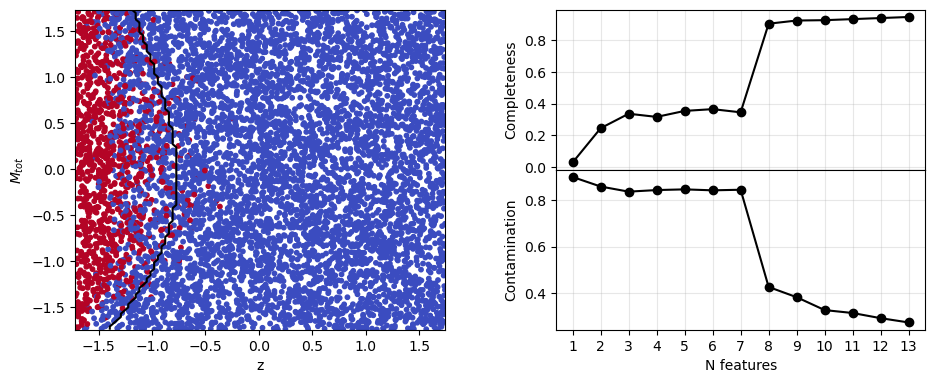

In [24]:
plots(rbf, X_train[:,[7,9]], y_train, completeness_rbf, contamination_rbf)

#### With PCA

In [212]:
rbf_pca = SVC(kernel='rbf', class_weight='balanced', C = best_c_pca, gamma = best_gamma)
completeness_rbf_pca, contamination_rbf_pca, confusion_rbf_pca = compl_cont(rbf_pca, X_train_pca, X_test_pca, y_train_pca, y_test)

100%|██████████| 13/13 [00:39<00:00,  3.01s/it]


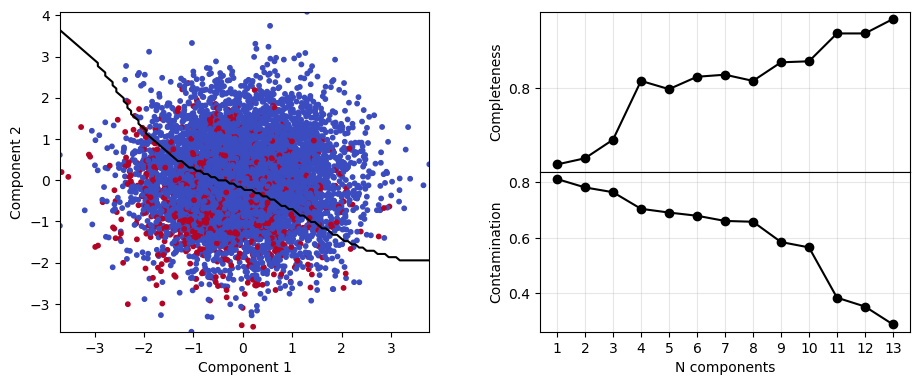

In [213]:
plots(rbf_pca, X_train_pca[:,:2], y_train_pca, completeness_rbf_pca, contamination_rbf_pca, red = True)

In [214]:
print('Without PCA:')
print('Completeness:\n', completeness_rbf)
print('Contamination:\n', contamination_rbf)
print('\nWith PCA:')
print('Completeness:\n', completeness_rbf_pca)
print('Contamination:\n', contamination_rbf_pca)

Without PCA:
Completeness:
 [0.38752784 0.26057906 0.30734967 0.27839644 0.31180401 0.30066815
 0.34075724 0.86414254 0.86636971 0.87973274 0.84187082 0.85300668
 0.86636971]
Contamination:
 [0.85807504 0.85749086 0.83859649 0.84957882 0.86354776 0.85878661
 0.84045881 0.40490798 0.34511785 0.26851852 0.25736739 0.22312373
 0.20449898]

With PCA:
Completeness:
 [0.63474388 0.6481069  0.68819599 0.81514477 0.79732739 0.82405345
 0.8285078  0.81514477 0.85523385 0.85746102 0.91759465 0.91759465
 0.94877506]
Contamination:
 [0.8121292  0.78169542 0.76448171 0.70460048 0.69111303 0.67965368
 0.66089335 0.65794393 0.58486486 0.56546275 0.38415546 0.35220126
 0.28762542]


In [215]:
print('Confusion matrix\nWithout PCA:\n', confusion_rbf[np.argmax(completeness_rbf)])
print('\nWith PCA:\n', confusion_rbf_pca[np.argmax(completeness_rbf_pca)])

Confusion matrix
Without PCA:
 [[2406  145]
 [  54  395]]

With PCA:
 [[2379  172]
 [  23  426]]


## Decision tree classifier

In this case 'entropy' works better

In [158]:
depthrange = np.arange(1, 11)
k = 5
grid = GridSearchCV(DecisionTreeClassifier(criterion='entropy', class_weight='balanced'), \
                    {'max_depth': depthrange}, cv= k)
grid.fit(X_train, y_train)
best_depth = grid.best_params_['max_depth']
print(best_depth)

9


#### Without PCA

In [216]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=4,  class_weight='balanced')
completeness_dtc, contamination_dtc, confusion_dtc = compl_cont(dtc, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:00<00:00, 21.78it/s]


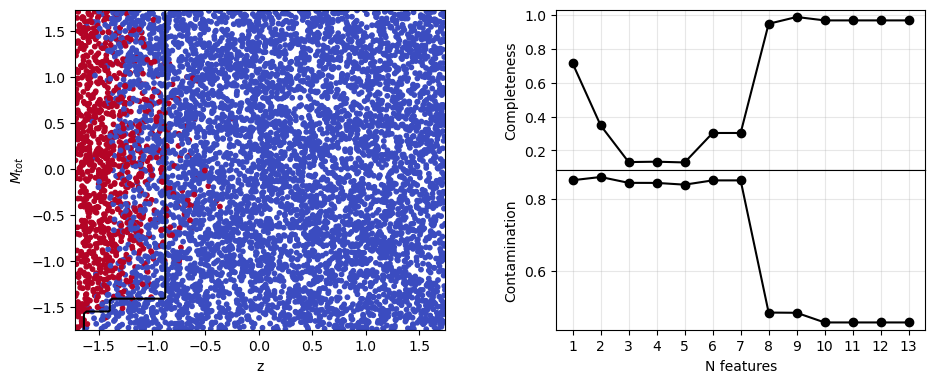

In [217]:
plots(dtc, X_train[:,[7,9]], y_train, completeness_dtc, contamination_dtc)

#### With PCA

In [218]:
completeness_dtc_pca, contamination_dtc_pca, confusion_dtc_pca = compl_cont(dtc, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:00<00:00, 21.58it/s]


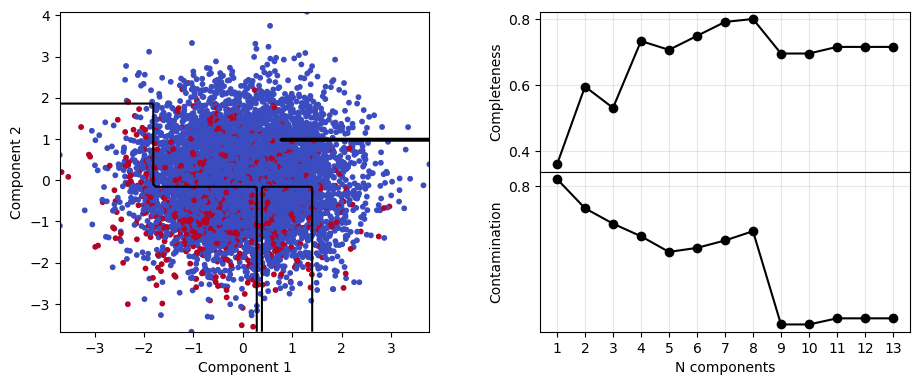

In [219]:
plots(dtc_pca, X_train_pca[:,:2], y_train_pca, completeness_dtc_pca, contamination_dtc_pca, red = True)

In [220]:
print('Without PCA:')
print('Completeness:\n', completeness_dtc)
print('Contamination:\n', contamination_dtc)
print('\nWith PCA:')
print('Completeness:\n', completeness_dtc_pca)
print('Contamination:\n', contamination_dtc_pca)

Without PCA:
Completeness:
 [0.71269488 0.34743875 0.13140312 0.13363029 0.12917595 0.30289532
 0.30289532 0.94654788 0.98663697 0.96659243 0.96659243 0.96659243
 0.96659243]
Contamination:
 [0.85116279 0.86008969 0.84391534 0.84375    0.83888889 0.8507135
 0.8507135  0.48547215 0.48488372 0.45817728 0.45817728 0.45817728
 0.45817728]

With PCA:
Completeness:
 [0.35857461 0.59465479 0.53006682 0.73273942 0.70601336 0.74832962
 0.79064588 0.79955457 0.69487751 0.69487751 0.71492205 0.71492205
 0.71492205]
Contamination:
 [0.80508475 0.78398058 0.77290076 0.7638191  0.75253708 0.75545852
 0.76078167 0.76748705 0.70028818 0.70028818 0.70469181 0.70469181
 0.70469181]


In [221]:
print('Confusion matrix\nWithout PCA:\n', confusion_dtc[np.argmax(completeness_dtc)])
print('\nWith PCA:\n', confusion_dtc_pca[np.argmax(completeness_dtc_pca)])

Confusion matrix
Without PCA:
 [[2134  417]
 [   6  443]]

With PCA:
 [[1366 1185]
 [  90  359]]


In [222]:
depths = np.arange(1,11)
compl = []
cont = []
compl_pca = []
cont_pca = []
for d in depths:
    dec = DecisionTreeClassifier(criterion='entropy', max_depth=d,  class_weight='balanced')
    compl_dtc, cont_dtc, conf_dtc = compl_cont(dec, X_train, X_test, y_train, y_test)
    compl_dtc_pca, cont_dtc_pca, conf_dtc_pca = compl_cont(dec, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

    compl.append(max(compl_dtc))
    cont.append(cont_dtc[np.argmax(compl_dtc)])

    compl_pca.append(max(compl_dtc_pca))
    cont_pca.append(cont_dtc_pca[np.argmax(compl_dtc_pca)])

100%|██████████| 13/13 [00:01<00:00, 11.61it/s]


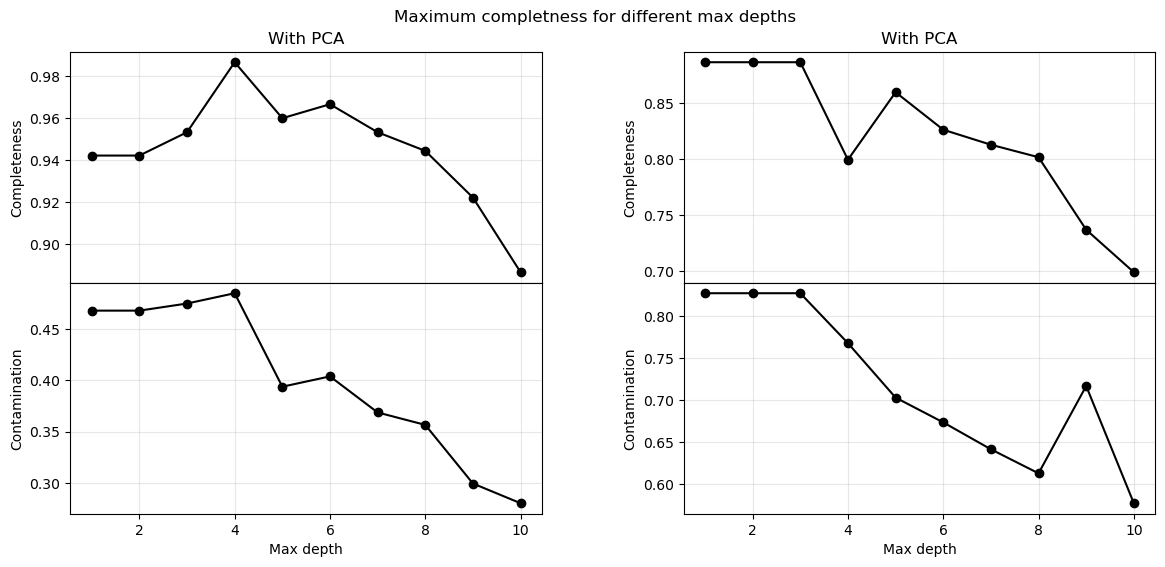

In [223]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.3, 'hspace': 0})

axs[0,0].plot(depths, compl, color = 'black', marker = 'o')
axs[0,0].set_title('With PCA')
axs[0,0].set_ylabel('Completeness')
axs[0,0].grid(alpha=0.3)
axs[1,0].plot(depths, cont, color = 'black', marker = 'o')
axs[1,0].set_ylabel('Contamination')
axs[1,0].set_xlabel('Max depth')
axs[1,0].grid(alpha=0.3)

axs[0,1].plot(depths, compl_pca, color = 'black', marker = 'o')
axs[0,1].set_title('With PCA')
axs[0,1].set_ylabel('Completeness')
axs[0,1].grid(alpha=0.3)
axs[1,1].plot(depths, cont_pca, color = 'black', marker = 'o')
axs[1,1].set_ylabel('Contamination')
axs[1,1].set_xlabel('Max depth')
axs[1,1].grid(alpha=0.3)

plt.suptitle('Maximum completness for different max depths', y=0.95)
plt.show()

## Bagging

In this case 'gini' works better

#### Without PCA

In [230]:
bag = BaggingClassifier(DecisionTreeClassifier(criterion='gini', class_weight='balanced', max_depth=4), \
                        n_estimators=500, max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)
completeness_bag, contamination_bag, confusion_bag = compl_cont(bag, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


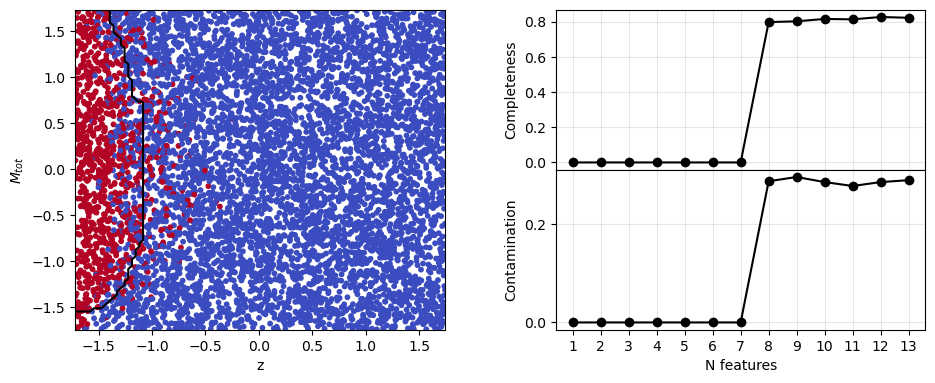

In [231]:
plots(bag, X_train[:,[7,9]], y_train, completeness_bag, contamination_bag)

#### With PCA

In [232]:
completeness_bag_pca, contamination_bag_pca, confusion_bag_pca = compl_cont(bag, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


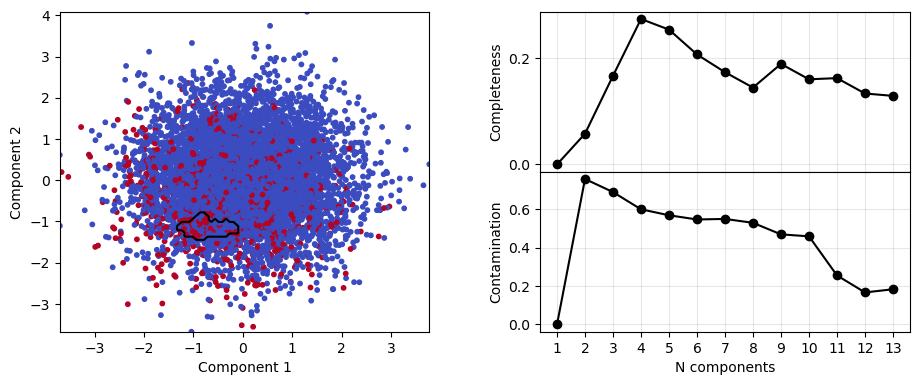

In [233]:
plots(bag, X_train_pca[:,:2], y_train_pca, completeness_bag_pca, contamination_bag_pca, red = True)

In [234]:
print('Without PCA:')
print('Completeness:\n', completeness_bag)
print('Contamination:\n', contamination_bag)
print('\nWith PCA:')
print('Completeness:\n', completeness_bag_pca)
print('Contamination:\n', contamination_bag_pca)

Without PCA:
Completeness:
 [0.         0.         0.         0.         0.         0.
 0.         0.79732739 0.80178174 0.81514477 0.81291759 0.82628062
 0.82182628]
Contamination:
 [0.         0.         0.         0.         0.         0.
 0.         0.28685259 0.29549902 0.28515625 0.27722772 0.28516378
 0.28901734]

With PCA:
Completeness:
 [0.         0.05790646 0.16703786 0.27394209 0.25389755 0.20712695
 0.17371938 0.14476615 0.18930958 0.16035635 0.16258352 0.13363029
 0.12917595]
Contamination:
 [0.         0.75700935 0.68879668 0.59934853 0.56818182 0.54634146
 0.54913295 0.52898551 0.46875    0.45864662 0.25510204 0.16666667
 0.18309859]


In [235]:
print('Confusion matrix\nWithout PCA:\n', confusion_bag[np.argmax(completeness_bag)])
print('\nWith PCA:\n', confusion_bag_pca[np.argmax(completeness_bag_pca)])

Confusion matrix
Without PCA:
 [[2403  148]
 [  78  371]]

With PCA:
 [[2367  184]
 [ 326  123]]


## Random Forest

In [154]:
depthrange = np.arange(1, 11)
k = 5
grid = GridSearchCV(RandomForestClassifier(criterion='entropy', class_weight='balanced', n_jobs=-1), \
                    {'max_depth': depthrange}, cv= k)
grid.fit(X_train, y_train)
best_depth = grid.best_params_['max_depth']
print(best_depth)

10


#### Without PCA

In [236]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=5, class_weight='balanced', n_jobs=-1)
completeness_rfc, contamination_rfc, confusion_rfc = compl_cont(rfc, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


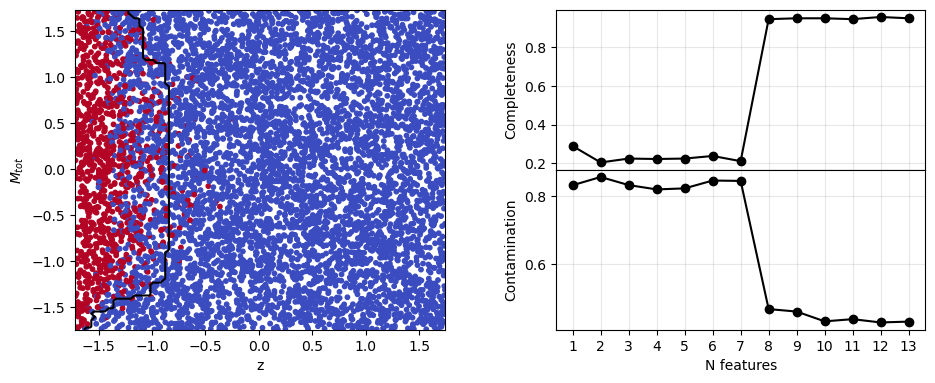

In [237]:
plots(rfc, X_train[:,[7,9]], y_train, completeness_rfc, contamination_rfc)

#### With PCA

In [238]:
completeness_rfc_pca, contamination_rfc_pca, confusion_rfc_pca = compl_cont(rfc, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


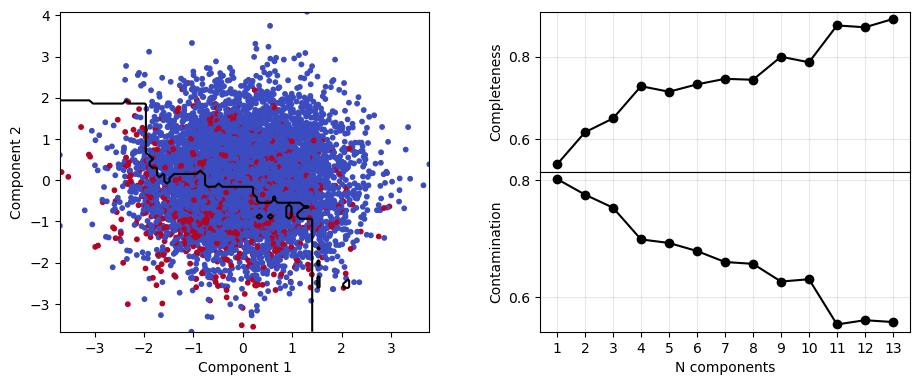

In [239]:
plots(rfc, X_train_pca[:,:2], y_train_pca, completeness_rfc_pca, contamination_rfc_pca, red = True)

In [240]:
print('Without PCA:')
print('Completeness:\n', completeness_rfc)
print('Contamination:\n', contamination_rfc)
print('\nWith PCA:')
print('Completeness:\n', completeness_rfc_pca)
print('Contamination:\n', contamination_rfc_pca)

Without PCA:
Completeness:
 [0.28953229 0.20489978 0.22494432 0.22271715 0.22494432 0.23830735
 0.21158129 0.94432071 0.94877506 0.94877506 0.94432071 0.95545657
 0.94877506]
Contamination:
 [0.83182406 0.85602504 0.83222591 0.81949458 0.82249561 0.84559885
 0.84451718 0.46733668 0.46007605 0.43124166 0.43766578 0.428
 0.43048128]

With PCA:
Completeness:
 [0.5389755  0.6169265  0.65033408 0.72828508 0.71492205 0.73273942
 0.74610245 0.74387528 0.79955457 0.78619154 0.8752784  0.87082405
 0.8908686 ]
Contamination:
 [0.80212592 0.77534469 0.75296108 0.69861751 0.69252874 0.67871094
 0.65989848 0.65673176 0.6264308  0.63036649 0.55290102 0.56017998
 0.55703212]


In [241]:
print('Confusion matrix\nWithout PCA:\n', confusion_rfc[np.argmax(completeness_rfc)])
print('\nWith PCA:\n', confusion_rfc_pca[np.argmax(completeness_rfc_pca)])

Confusion matrix
Without PCA:
 [[2230  321]
 [  20  429]]

With PCA:
 [[2048  503]
 [  49  400]]


In [242]:
depths = np.arange(1,11)
cmp_rfc = []
con_rfc = []
cmp_pca_rfc = []
con_pca_rfc = []
for d in depths:
    rfc = RandomForestClassifier(criterion='entropy', max_depth=d, class_weight='balanced', n_jobs=-1)
    compl_rfc, cont_rfc, conf_rfc = compl_cont(rfc, X_train, X_test, y_train, y_test)
    compl_rfc_pca, cont_rfc_pca, conf_rfc_pca = compl_cont(rfc, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

    cmp_rfc.append(max(compl_rfc))
    con_rfc.append(cont_rfc[np.argmax(compl_rfc)])

    cmp_pca_rfc.append(max(compl_rfc_pca))
    con_pca_rfc.append(cont_rfc_pca[np.argmax(compl_rfc_pca)])

100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


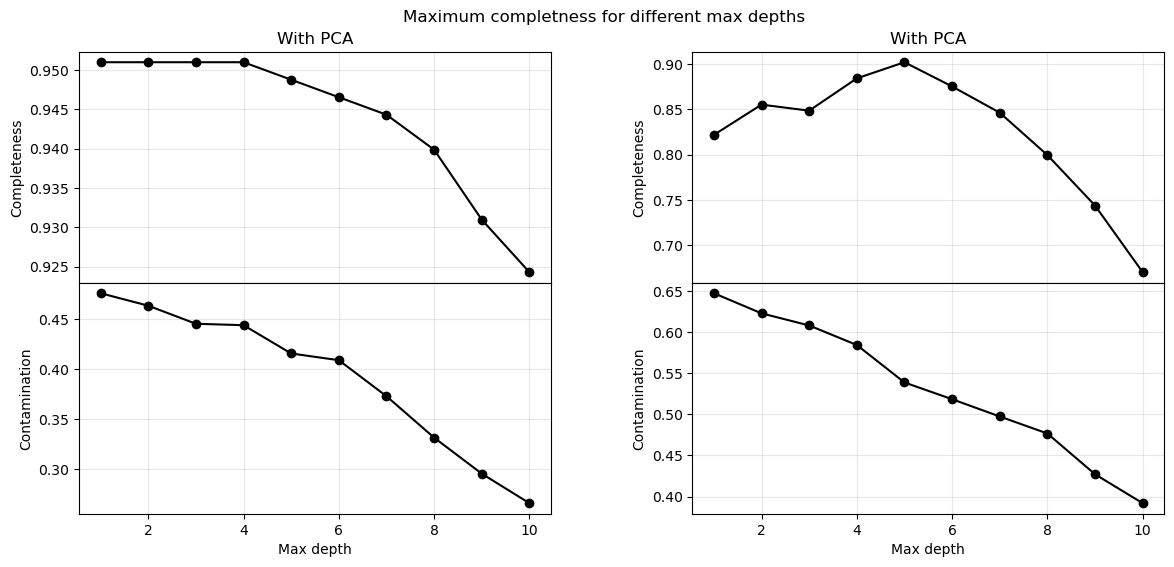

In [243]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.3, 'hspace': 0})

axs[0,0].plot(depths, cmp_rfc, color = 'black', marker = 'o')
axs[0,0].set_title('With PCA')
axs[0,0].set_ylabel('Completeness')
axs[0,0].grid(alpha=0.3)
axs[1,0].plot(depths, con_rfc, color = 'black', marker = 'o')
axs[1,0].set_ylabel('Contamination')
axs[1,0].set_xlabel('Max depth')
axs[1,0].grid(alpha=0.3)

axs[0,1].plot(depths, cmp_pca_rfc, color = 'black', marker = 'o')
axs[0,1].set_title('With PCA')
axs[0,1].set_ylabel('Completeness')
axs[0,1].grid(alpha=0.3)
axs[1,1].plot(depths, con_pca_rfc, color = 'black', marker = 'o')
axs[1,1].set_ylabel('Contamination')
axs[1,1].set_xlabel('Max depth')
axs[1,1].grid(alpha=0.3)

plt.suptitle('Maximum completness for different max depths', y=0.95)
plt.show()

## Gradient boosting

#### Without PCA

In [245]:
boost = GradientBoostingClassifier(loss='exponential', max_depth= 6)
completeness_boost, contamination_boost, confusion_boost = compl_cont(boost, X_train, X_test, y_train, y_test)

100%|██████████| 13/13 [00:58<00:00,  4.51s/it]


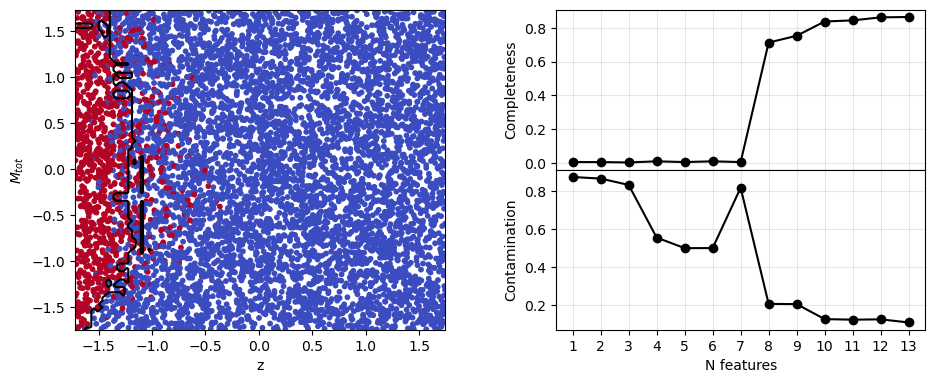

In [246]:
plots(boost, X_train[:,[7,9]], y_train, completeness_boost, contamination_boost)

#### With PCA

In [247]:
completeness_boost_pca, contamination_boost_pca, confusion_boost_pca = compl_cont(boost, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

100%|██████████| 13/13 [00:58<00:00,  4.50s/it]


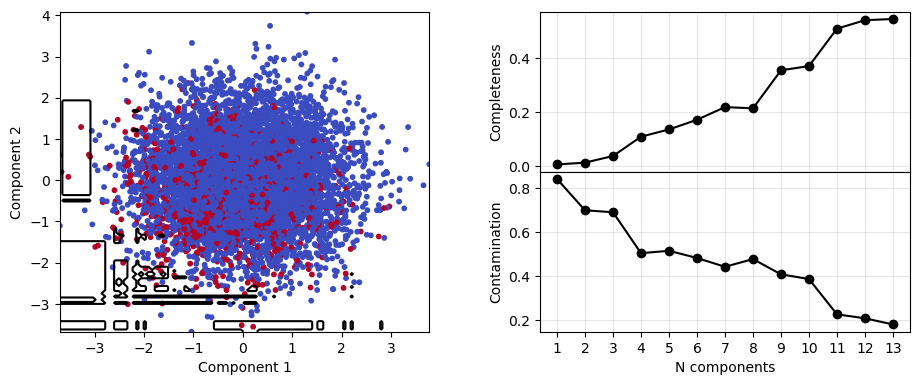

In [248]:
plots(boost, X_train_pca[:,:2], y_train_pca, completeness_boost_pca, contamination_boost_pca, red = True)

In [249]:
print('Without PCA:')
print('Completeness:\n', completeness_boost)
print('Contamination:\n', contamination_boost)
print('\nWith PCA:')
print('Completeness:\n', completeness_boost_pca)
print('Contamination:\n', contamination_boost_pca)

Without PCA:
Completeness:
 [0.00445434 0.00445434 0.00222717 0.00890869 0.00445434 0.00890869
 0.00445434 0.71269488 0.75278396 0.83741648 0.844098   0.86191537
 0.86414254]
Contamination:
 [0.875      0.86666667 0.83333333 0.55555556 0.5        0.5
 0.81818182 0.20595533 0.20470588 0.1255814  0.12268519 0.12443439
 0.10804598]

With PCA:
Completeness:
 [0.00668151 0.01336303 0.03786192 0.1091314  0.13585746 0.1714922
 0.21826281 0.21380846 0.35412027 0.36971047 0.5077951  0.5389755
 0.54342984]
Contamination:
 [0.84210526 0.7        0.69090909 0.50505051 0.51587302 0.48322148
 0.44318182 0.47826087 0.40892193 0.38745387 0.22711864 0.20915033
 0.18120805]


In [250]:
print('Confusion matrix\nWithout PCA:\n', confusion_boost[np.argmax(completeness_boost)])
print('\nWith PCA:\n', confusion_boost_pca[np.argmax(completeness_boost_pca)])

Confusion matrix
Without PCA:
 [[2504   47]
 [  61  388]]

With PCA:
 [[2497   54]
 [ 205  244]]


In [174]:
depths = np.arange(1,11)
cmp_boost = []
con_boost = []
cmp_pca_boost = []
con_pca_boost = []
for d in depths:
    boost = GradientBoostingClassifier(loss='exponential', max_depth= d)
    compl_boost, cont_boost, conf_boost = compl_cont(boost, X_train, X_test, y_train, y_test)
    compl_boost_pca, cont_boost_pca, conf_boost_pca = compl_cont(boost, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

    cmp_boost.append(max(compl_boost))
    con_boost.append(cont_boost[np.argmax(compl_boost)])

    cmp_pca_boost.append(max(compl_boost_pca))
    con_pca_boost.append(cont_boost_pca[np.argmax(compl_boost_pca)])

100%|██████████| 13/13 [01:56<00:00,  8.93s/it]


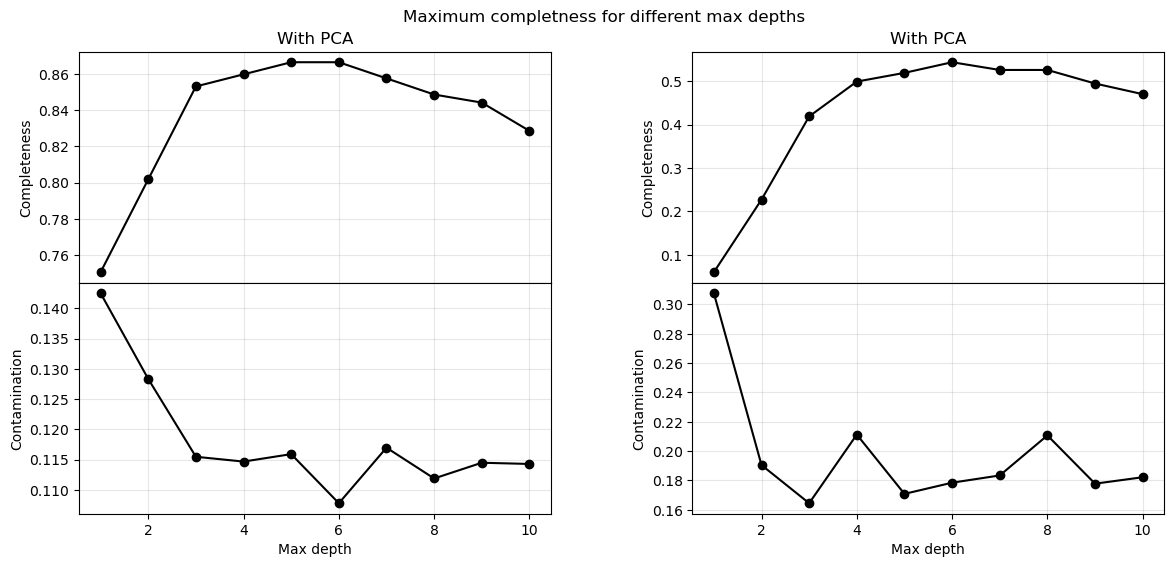

In [175]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.3, 'hspace': 0})

axs[0,0].plot(depths, cmp_boost, color = 'black', marker = 'o')
axs[0,0].set_title('With PCA')
axs[0,0].set_ylabel('Completeness')
axs[0,0].grid(alpha=0.3)
axs[1,0].plot(depths, con_boost, color = 'black', marker = 'o')
axs[1,0].set_ylabel('Contamination')
axs[1,0].set_xlabel('Max depth')
axs[1,0].grid(alpha=0.3)

axs[0,1].plot(depths, cmp_pca_boost, color = 'black', marker = 'o')
axs[0,1].set_title('With PCA')
axs[0,1].set_ylabel('Completeness')
axs[0,1].grid(alpha=0.3)
axs[1,1].plot(depths, con_pca_boost, color = 'black', marker = 'o')
axs[1,1].set_ylabel('Contamination')
axs[1,1].set_xlabel('Max depth')
axs[1,1].grid(alpha=0.3)

plt.suptitle('Maximum completness for different max depths', y=0.95)
plt.show()